In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import warnings

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning

import mnist_loader

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Carregando o MNIST dataset

In [3]:
# Loading MNIST dataset
training_data, validation_data, test_data = mnist_loader.load_data()

X_train, Y_train = np.concatenate((training_data[0], validation_data[0])), np.concatenate((training_data[1], validation_data[1]))
X_test, Y_test = test_data[0], test_data[1]

Definindo os parâmetros da MLP

In [4]:
# Definir a quantidade de camadas escondidas
def random_hidden_layers():
    hidden_layer = [random.randint(2, 100)]
    while random.uniform(0.0, 1.0) > 0.4:
        hidden_layer.append(random.randint(2, 100))
    return hidden_layer

def random_params_mlp(verbose=False, num_epochs=1000, tol=0.0001):
    return MLPClassifier(
        activation=random.choice(['identity', 'logistic', 'tanh', 'relu']),
        batch_size=100,
        early_stopping=True,
        hidden_layer_sizes=random_hidden_layers(),
        learning_rate_init=round(random.uniform(0.0001, 0.1), 4),
        max_iter=num_epochs,
        n_iter_no_change=3,
        solver=random.choice(['adam', 'sgd', 'lbfgs']),
        tol=tol
    )

Fazendo um "GridSearch" sobre a camada escondida

In [5]:
best_mlp = {
    'model': 0,
    'fit_time': 0,
    'accuracy': 0,
    'precision': 0,
    'recall': 0,
}

print("Activation | Solver | LR | Hidden Layers: Accuracy | Total Time")
for _ in range(5):
    mlp = random_params_mlp()

    start = time.time()
    mlp.fit(X_train, Y_train)
    end = time.time()
    total_time = round(end - start, 1)

    mlp_predictions = mlp.predict(X_test)
    accuracy = accuracy_score(Y_test, mlp_predictions)
    print(f"{mlp.get_params()['activation']} | {mlp.get_params()['solver']} | {mlp.get_params()['learning_rate_init']} \
| {mlp.get_params()['hidden_layer_sizes']}: {accuracy} | {total_time}s")

    if accuracy > best_mlp['accuracy']:
        best_mlp['model'] = mlp
        best_mlp['accuracy'] = accuracy
        best_mlp['fit_time'] = total_time

print(f"\nBest Params Accuracy: {best_mlp['accuracy']}")

Activation | Solver | LR | Hidden Layers: Accuracy | Total Time
tanh | sgd | 0.0809 | [34, 99]: 0.9659 | 9.1s
identity | adam | 0.076 | [87, 40]: 0.889 | 13.0s
relu | sgd | 0.0879 | [39]: 0.9698 | 8.3s
logistic | adam | 0.0112 | [16, 40]: 0.9467 | 6.8s
identity | lbfgs | 0.0854 | [37]: 0.921 | 229.2s

Best Params Accuracy: 0.9698


Verificando as predições da MLP sobre o subconjunto de testes

In [6]:
mlp = best_mlp['model']

In [7]:
mlp_predictions = mlp.predict(X_test)

In [8]:
accuracy = accuracy_score(Y_test, mlp_predictions)
precision = precision_score(Y_test, mlp_predictions, average='weighted')
recall = recall_score(Y_test, mlp_predictions, average='weighted')


In [9]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}") # PRECISA AJUSTAR O PRECISION E O RECALL PARA MULTICLASS
print(f"Recall: {recall}")

Accuracy: 0.9698
Precision: 0.9698747256305175
Recall: 0.9698


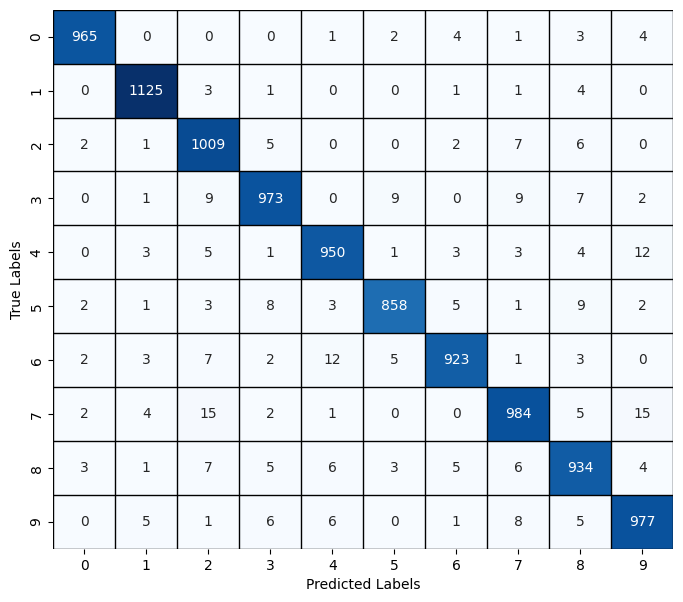

In [10]:
# Confusion Matrix
cm = confusion_matrix(Y_test, mlp_predictions)
plt.figure(figsize=(8, 7))

# Heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=range(10), yticklabels=range(10))

# Labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(11):
    plt.hlines(i, xmin=0, xmax=10, colors='black', linestyles='solid', linewidth=1)
    plt.vlines(i, ymin=0, ymax=10, colors='black', linestyles='solid', linewidth=1)

plt.show()

Salvando o modelo treinado

In [11]:
filename = 'test_model.plk'

In [12]:
# Salvando o modelo em um arquivo
with open(filename, 'wb') as f:
    pickle.dump(mlp, f)

In [13]:
# # Carregando um modelo salvo
# with open(filename, 'rb') as f:
#     mlp = pickle.load(f)

Media e Desvio Padrão do melhor conjunto de parâmetros

In [14]:
# Criando 10 modelos com os parâmetros selecionados e salvando seus resultados
model_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fit_time': [],
}

for _ in range(10):
    start = time.time()
    mlp.fit(X_train, Y_train)
    end = time.time()
    model_scores['fit_time'].append(round(end - start, 1))

    mlp_predictions = mlp.predict(X_test)
    model_scores['accuracy'].append(accuracy_score(Y_test, mlp_predictions))
    model_scores['precision'].append(precision_score(Y_test, mlp_predictions, average='weighted'))
    model_scores['recall'].append(recall_score(Y_test, mlp_predictions, average='weighted'))

In [15]:
data = {
    'Params': ['C1'],
    'Mean Accuracy': [np.mean(model_scores['accuracy'])],
    'Std Accuracy': [np.std(model_scores['accuracy'])],
    'Mean Precision': [np.mean(model_scores['precision'])],
    'Std Precision': [np.std(model_scores['precision'])],
    'Mean Recall': [np.mean(model_scores['recall'])],
    'Std Recall': [np.std(model_scores['recall'])],
    'Mean Time': [np.mean(model_scores['fit_time'])],
    'Std Time': [np.std(model_scores['fit_time'])],
}
df = pd.DataFrame(data)
df

,Params,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean Time,Std Time
0,C1,0.96871,0.001616,0.968857,0.001574,0.96871,0.001616,7.22,1.198165
